In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas

In [2]:
## Generate Data
import pandas
import numpy as np
df = pandas.read_csv('hudson-bay-linx-hare.csv',header=1)

year = df['Year']
lynx = df['Lynx']
hare = df['Hare']

times = np.array(year,dtype=float) - 1899
yobs = np.array([hare,lynx]).T 
yobs_norm = yobs / yobs.std(axis=0)
N = len(year)

In [3]:
from scipy.integrate import ode
alpha  = 1
beta=0.1
gamma=1.5
delta=0.75 * 0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha*state[0] -   beta*state[0]*state[1],
                  -gamma*state[1] + delta*state[0]*state[1]])

t = np.linspace(0, 24,  50)              # time
X0 = np.array([10, 5])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha ,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

np.random.seed(0)
yobs = X.T #* np.random.lognormal(mean=0,sigma=0.1,size=X.T.shape)  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
times = np.arange(1, len(t) + 1).astype(float)
print(yobs.std(axis=0))
yobs_norm = yobs/ yobs.std(axis=0)
N = len(times)




[11.01423801  6.72044375]
[11.01423801  6.72044375]
[11.01423801  6.72044375]


In [4]:
lk_data = {
    'N' : N,
    'ts' : times.tolist(),
    'y_init' : yobs_norm[0].tolist(),
    'y' : yobs_norm.tolist(),
    'slab_df' : 4.0,
    'slab_scale' : 2.0,
    'd' : 10,
}

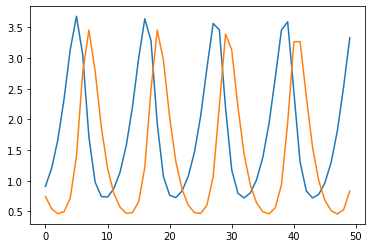

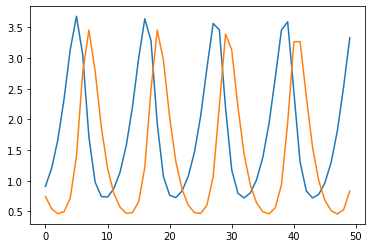

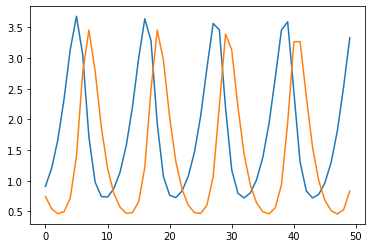

In [5]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(yobs_norm)
plt.show()

In [6]:
inp = yobs_norm
u = inp[:,0]
v = inp[:,1]

θ = np.array([u,v,u*v,u**2,v**2]).T

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
dx = sfd(inp)
guess = np.linalg.lstsq(θ,dx)[0]

/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will 

In [7]:
guess

array([[ 0.62629261,  0.0049652 ],
       [-0.15541501, -0.78513698],
       [-0.17240949,  0.20157677],
       [-0.08536599,  0.05451585],
       [-0.01971077,  0.11507658]])

array([[ 0.62629261,  0.0049652 ],
       [-0.15541501, -0.78513698],
       [-0.17240949,  0.20157677],
       [-0.08536599,  0.05451585],
       [-0.01971077,  0.11507658]])

array([[ 0.62629261,  0.0049652 ],
       [-0.15541501, -0.78513698],
       [-0.17240949,  0.20157677],
       [-0.08536599,  0.05451585],
       [-0.01971077,  0.11507658]])

In [8]:
def my_init():
    return {"sigma" : [0.1, 0.1],
            "theta" : guess.flatten().tolist(),
            "tau" : 0.1,
            "lambda" : np.ones(10).tolist(), #[8.4, 0.88, 1.6, 12.8, 10.0, 19.0],
            "z_init" : yobs_norm[0].tolist(),
            "c" : 2.5,
            "my_z" : (guess.flatten() / 0.1).tolist(),  #[1.17, 0.083, 0.16, -1.1, -1.0, 1.0 ]
    }

In [9]:
my_init()

{'sigma': [0.1, 0.1],
 'theta': [0.6262926142152111,
  0.004965202324533493,
  -0.1554150135696663,
  -0.7851369806178922,
  -0.17240948717845636,
  0.20157677351432002,
  -0.085365987619789,
  0.05451585383318802,
  -0.019710770112952414,
  0.11507657662735485],
 'tau': 0.1,
 'lambda': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'z_init': [0.9079157354119445, 0.74399848949034],
 'c': 2.5,
 'my_z': [6.262926142152111,
  0.04965202324533493,
  -1.554150135696663,
  -7.851369806178921,
  -1.7240948717845634,
  2.0157677351432,
  -0.85365987619789,
  0.5451585383318802,
  -0.19710770112952414,
  1.1507657662735484]}

{'sigma': [0.1, 0.1],
 'theta': [0.6262926142152111,
  0.004965202324533493,
  -0.1554150135696663,
  -0.7851369806178922,
  -0.17240948717845636,
  0.20157677351432002,
  -0.085365987619789,
  0.05451585383318802,
  -0.019710770112952414,
  0.11507657662735485],
 'tau': 0.1,
 'lambda': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'z_init': [0.9079157354119445, 0.74399848949034],
 'c': 2.5,
 'my_z': [6.262926142152111,
  0.04965202324533493,
  -1.554150135696663,
  -7.851369806178921,
  -1.7240948717845634,
  2.0157677351432,
  -0.85365987619789,
  0.5451585383318802,
  -0.19710770112952414,
  1.1507657662735484]}

{'sigma': [0.1, 0.1],
 'theta': [0.6262926142152111,
  0.004965202324533493,
  -0.1554150135696663,
  -0.7851369806178922,
  -0.17240948717845636,
  0.20157677351432002,
  -0.085365987619789,
  0.05451585383318802,
  -0.019710770112952414,
  0.11507657662735485],
 'tau': 0.1,
 'lambda': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'z_init': [0.9079157354119445, 0.74399848949034],
 'c': 2.5,
 'my_z': [6.262926142152111,
  0.04965202324533493,
  -1.554150135696663,
  -7.851369806178921,
  -1.7240948717845634,
  2.0157677351432,
  -0.85365987619789,
  0.5451585383318802,
  -0.19710770112952414,
  1.1507657662735484]}

In [20]:
lotka_stan = """
functions {
  real[] dz_dt(real t,       // time
               real[] z,     // system state {prey, predator}
               real[] theta, // parameters
               real[] x_r,   // unused data
               int[] x_i) {
    real u = z[1];
    real v = z[2];

    real du_dt = theta[1] * u + theta[3] * v + theta[5] * u * v + theta[7] * u * u + theta[9] * v * v - 1e-3 * u * u * u;
    real dv_dt = theta[2] * u + theta[4] * v + theta[6] * u * v + theta[8] + u * u + theta[10] * v * v - 1e-3 * v * v * v;

    return { du_dt, dv_dt };
  }
}
data {
  int<lower = 0> N;          // number of measurement times
  real ts[N];                // measurement times > 0
  real y_init[2];            // initial measured populations
  real<lower = 0> y[N, 2];   // measured populations
  real slab_df;
  real slab_scale;
  int<lower = 0> d;
}
parameters {
  vector <lower = 0>[d] lambda;
  real<lower = 0> z_init[2];  // initial population
  vector <lower = 0>[2] sigma;   // measurement errors
  real<lower=0> tau;
  vector[d] my_z;
  real <lower=0> caux;
  
}
transformed parameters {
  vector<lower=0>[d] lambda_tilde;
  real theta[d];
  real z[N,2];
  lambda_tilde = sqrt( caux * square(lambda) ./ (caux + tau^2*square(lambda)) ); 
  for (k in 1:d){
     theta[k] = my_z[k] * lambda_tilde[k] * tau;}
  z = integrate_ode_rk45(dz_dt, z_init, 0, ts, theta,
                         rep_array(0.0, 0), rep_array(0, 0),
                         1e-5, 1e-3, 2e3);
}
model {
  lambda ~ student_t(1.0, 0.0, 1.0);
  tau ~ student_t(1.0, 0.0, 0.01);
  caux ~ inv_gamma(0.5 * slab_df, 0.5 * slab_df * square(slab_scale));
  my_z ~ normal(0.0, 1.0);
  sigma ~ lognormal(-1, 0.1);
  z_init ~ lognormal(log(1), 1);
  for (k in 1:2) {
    y_init[k] ~ lognormal(log(z_init[k]), sigma[k]);
    y[ , k] ~ lognormal(log(z[, k]), sigma[k]);
  }
}
generated quantities {
  real y_init_rep[2];
  real y_rep[N, 2];
  for (k in 1:2) {
    y_init_rep[k] = lognormal_rng(log(z_init[k]), sigma[k]);
    for (n in 1:N)
      y_rep[n, k] = lognormal_rng(log(z[n, k]), sigma[k]);
  }
}"""

In [21]:
import pystan
sm = pystan.StanModel(model_code=lotka_stan)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5366f940aef93b0bdbf6ec0226d73d8 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5366f940aef93b0bdbf6ec0226d73d8 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f5366f940aef93b0bdbf6ec0226d73d8 NOW.


In [22]:
fit = sm.sampling(data=lk_data, chains=2, algorithm='NUTS', seed=2, init=my_init, iter=1000)

In [23]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_f5366f940aef93b0bdbf6ec0226d73d8.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
lambda[1]           1.26    0.09   0.35   0.78   1.01   1.21    1.45    2.1     14   1.08
lambda[2]          35.55   32.82  51.69   1.92   2.13   8.97   46.85 187.61      2    1.4
lambda[3]           2.75    1.53   2.72   0.95   1.21   1.47    3.34  11.05      3    1.9
lambda[4]           2.89    2.82   3.18   0.08   0.14   1.01     5.1   10.7      1   2.22
lambda[5]           0.64    0.39   0.89   0.05   0.18   0.31    0.41   3.26      5   1.67
lambda[6]           1.21    0.89   0.96    0.1   0.27   1.46    1.98   3.08      1   4.04
lambda[7]           1.41    0.84   0.92   0.32   0.56    1.2    2.13   3.15      1   2.84
lambda[8]           5.83    4.92    5.6   0.79   1.03


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_f5366f940aef93b0bdbf6ec0226d73d8.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
lambda[1]           1.26    0.09   0.35   0.78   1.01   1.21    1.45    2.1     14   1.08
lambda[2]          35.55   32.82  51.69   1.92   2.13   8.97   46.85 187.61      2    1.4
lambda[3]           2.75    1.53   2.72   0.95   1.21   1.47    3.34  11.05      3    1.9
lambda[4]           2.89    2.82   3.18   0.08   0.14   1.01     5.1   10.7      1   2.22
lambda[5]           0.64    0.39   0.89   0.05   0.18   0.31    0.41   3.26      5   1.67
lambda[6]           1.21    0.89   0.96    0.1   0.27   1.46    1.98   3.08      1   4.04
lambda[7]           1.41    0.84   0.92   0.32   0.56    1.2    2.13   3.15      1   2.84
lambda[8]           5.83    4.92    5.6   0.79   1.03


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_f5366f940aef93b0bdbf6ec0226d73d8.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                    mean se_mean     sd   2.5%    25%    50%     75%  97.5%  n_eff   Rhat
lambda[1]           1.26    0.09   0.35   0.78   1.01   1.21    1.45    2.1     14   1.08
lambda[2]          35.55   32.82  51.69   1.92   2.13   8.97   46.85 187.61      2    1.4
lambda[3]           2.75    1.53   2.72   0.95   1.21   1.47    3.34  11.05      3    1.9
lambda[4]           2.89    2.82   3.18   0.08   0.14   1.01     5.1   10.7      1   2.22
lambda[5]           0.64    0.39   0.89   0.05   0.18   0.31    0.41   3.26      5   1.67
lambda[6]           1.21    0.89   0.96    0.1   0.27   1.46    1.98   3.08      1   4.04
lambda[7]           1.41    0.84   0.92   0.32   0.56    1.2    2.13   3.15      1   2.84
lambda[8]           5.83    4.92    5.6   0.79   1.03

INFO:numba.transforms:finding looplift candidates
INFO:numba.transforms:finding looplift candidates
INFO:numba.transforms:finding looplift candidates
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  """
/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  """


<Figure size 432x288 with 0 Axes>

/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  """


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

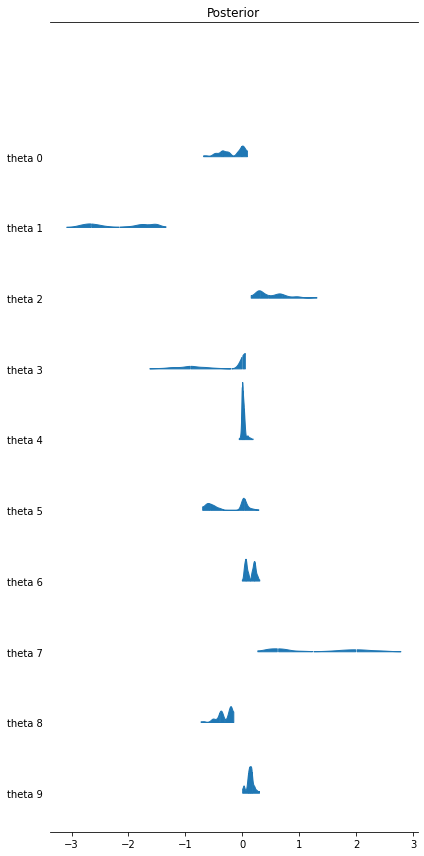

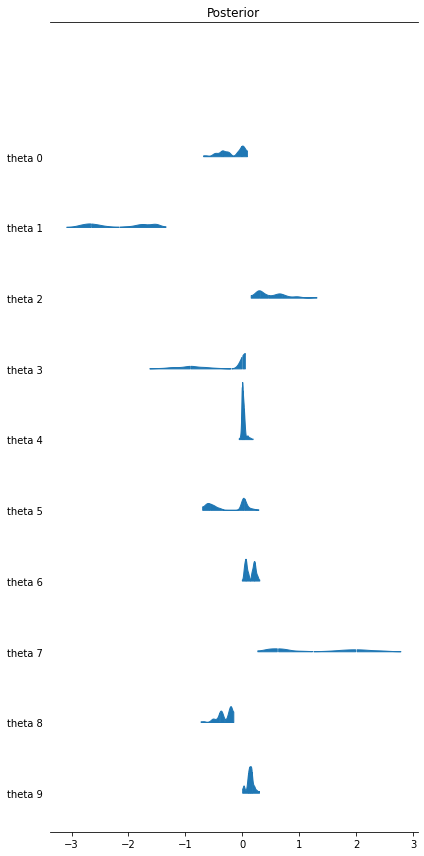

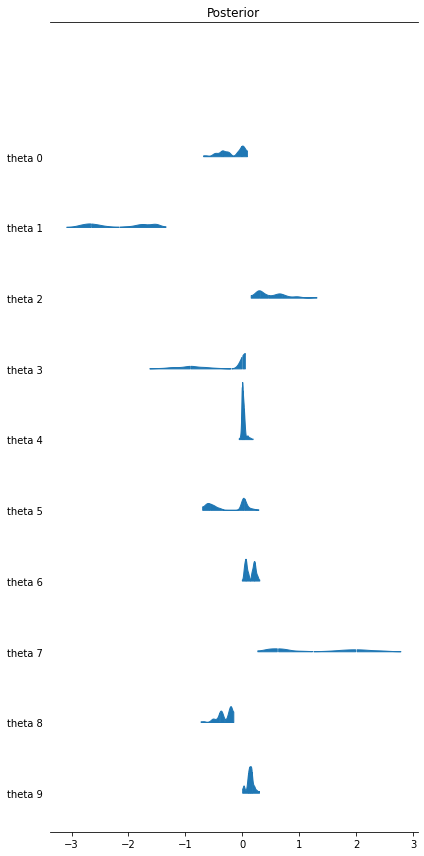

In [24]:
import arviz as az
plt.figure()
myplot = az.plot_forest(fit, var_names=['theta'], kind='ridgeplot', combined=True, figsize=(6,12), ridgeplot_quantiles=[.25, .5, .75])[0]
plt.title('Posterior')
plt.tight_layout()
plt.show()

In [15]:
fit.extract()['theta'].mean(axis=0) * 1/ (t[1] - t[0])

array([ 0.13849225, -5.84201951,  0.57583725, -2.90468498,  0.01541721,
        0.16222086,  0.08708144,  5.15345236, -0.40862811,  0.51106556])

array([ 0.13849225, -5.84201951,  0.57583725, -2.90468498,  0.01541721,
        0.16222086,  0.08708144,  5.15345236, -0.40862811,  0.51106556])

array([ 0.13849225, -5.84201951,  0.57583725, -2.90468498,  0.01541721,
        0.16222086,  0.08708144,  5.15345236, -0.40862811,  0.51106556])

In [16]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_54d97876b86f057f61e94d7b8abdd7e6.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                   mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
lambda[1]          0.47    0.12   0.29   0.03    0.28   0.49    0.6   1.19      6    1.7
lambda[2]          7.71    1.96   2.42   5.44    5.75    6.3   9.71  12.84      2   1.77
lambda[3]          3.65    2.71   2.91   0.47    0.76   3.48   6.09   8.83      1   2.66
lambda[4]          4.32    0.28   1.07   2.33    3.69   4.36   5.07    6.2     14   1.15
lambda[5]          2.26    1.83   1.98   0.28    0.49    1.5   4.12   5.89      1   5.11
lambda[6]          0.89    0.37   0.56   0.17     0.5   0.81   1.17    2.3      2   1.37
lambda[7]           0.5    0.47    0.6   0.03    0.04   0.19   0.81   2.16      2   1.96
lambda[8]         23.39   18.85  37.96   4.37    4.84   8.15 


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_54d97876b86f057f61e94d7b8abdd7e6.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                   mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
lambda[1]          0.47    0.12   0.29   0.03    0.28   0.49    0.6   1.19      6    1.7
lambda[2]          7.71    1.96   2.42   5.44    5.75    6.3   9.71  12.84      2   1.77
lambda[3]          3.65    2.71   2.91   0.47    0.76   3.48   6.09   8.83      1   2.66
lambda[4]          4.32    0.28   1.07   2.33    3.69   4.36   5.07    6.2     14   1.15
lambda[5]          2.26    1.83   1.98   0.28    0.49    1.5   4.12   5.89      1   5.11
lambda[6]          0.89    0.37   0.56   0.17     0.5   0.81   1.17    2.3      2   1.37
lambda[7]           0.5    0.47    0.6   0.03    0.04   0.19   0.81   2.16      2   1.96
lambda[8]         23.39   18.85  37.96   4.37    4.84   8.15 


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_54d97876b86f057f61e94d7b8abdd7e6.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

                   mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
lambda[1]          0.47    0.12   0.29   0.03    0.28   0.49    0.6   1.19      6    1.7
lambda[2]          7.71    1.96   2.42   5.44    5.75    6.3   9.71  12.84      2   1.77
lambda[3]          3.65    2.71   2.91   0.47    0.76   3.48   6.09   8.83      1   2.66
lambda[4]          4.32    0.28   1.07   2.33    3.69   4.36   5.07    6.2     14   1.15
lambda[5]          2.26    1.83   1.98   0.28    0.49    1.5   4.12   5.89      1   5.11
lambda[6]          0.89    0.37   0.56   0.17     0.5   0.81   1.17    2.3      2   1.37
lambda[7]           0.5    0.47    0.6   0.03    0.04   0.19   0.81   2.16      2   1.96
lambda[8]         23.39   18.85  37.96   4.37    4.84   8.15 